# https://github.com/danfenghong/Coupled-CNNs/tree/master

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! ls '/content/drive/MyDrive/Paper2_HSI_MASK_AutoEncoder_BS/FusionModel/'

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import scipy.io as sio
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.decomposition import PCA
from torch.nn.parameter import Parameter
import torchvision.transforms.functional as TF
import time
import mat73

2024-07-21 07:21:24.986344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
path='/content/drive/MyDrive/Paper2_HSI_MASK_AutoEncoder_BS/FusionModel/'

In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/2013_DFTC/'

2013_DFTC			     2013_IEEE_GRSS_DF_Contest_Samples_TR.mat
2013_IEEE_GRSS_DF_Contest_CASI.hdr   2013_IEEE_GRSS_DF_Contest_Samples_TR.roi
2013_IEEE_GRSS_DF_Contest_CASI.mat   2013_IEEE_GRSS_DF_Contest_Samples_TR.txt
2013_IEEE_GRSS_DF_Contest_CASI.tif   2013_IEEE_GRSS_DF_Contest_Samples_VA
2013_IEEE_GRSS_DF_Contest_LiDAR.hdr  2013_IEEE_GRSS_DF_Contest_Samples_VA.zip
2013_IEEE_GRSS_DF_Contest_LiDAR.mat  copyright.txt
2013_IEEE_GRSS_DF_Contest_LiDAR.tif


# Step 1: Load Data and Extract Training Samples

# Step 1： Define Class Information

In [ ]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 1251),
    (2, "Stressed grass", 1254),
    (3, "Synthetic grass", 697),
    (4, "Trees", 1244),
    (5, "Soil", 1242),
    (6, "Water", 325),
    (7, "Residential", 1268),
    (8, "Commercial", 1244),
    (9, "Road", 1252),
    (10, "Highway", 1227),
    (11, "Railway", 1235),
    (12, "Parking lot 1", 1233),
    (13, "Parking lot 2", 469),
    (14, "Tennis court", 428),
    (15, "Running track", 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name, "samples": samples} for class_number, class_name, samples in class_info}

# Step 2 Load Data

In [ ]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat('2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat('2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat('GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


# DataExtraction 1 Extract Training and Test Sampels

In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 11
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 11, 11, 144)
lidar_samples shape: (15029, 11, 11, 1)
labels shape: (15029,)


In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]
#training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

training_hsi_samples = np.array(training_hsi_samples)
training_lidar_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', training_hsi_samples.shape)
print('training_lidar_samples shape:', training_lidar_samples.shape)
print('training_labels shape:', training_labels.shape)

training_hsi_samples shape: (2832, 11, 11, 144)
training_lidar_samples shape: (2832, 11, 11, 1)
training_labels shape: (2832,)


In [ ]:
# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

hsi_training_samples shape: (2832, 11, 11, 144)
lidar_training_samples shape: (2832, 11, 11, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 11, 11, 144)
lidar_test_samples shape: (12197, 11, 11, 1)
test_labels shape: (12197,)


# Step 2: Convert the Data

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assume hsi_training_samples, lidar_training_samples, training_labels, hsi_test_samples, lidar_test_samples, and test_labels are already defined

# Ensure all labels are positive and zero-based
training_labels = training_labels - np.min(training_labels)
test_labels = test_labels - np.min(test_labels)

# Check unique values in labels to ensure they are within the valid range
print('Unique values in training_labels before adjustment:', np.unique(training_labels))
print('Unique values in test_labels before adjustment:', np.unique(test_labels))

# Convert the data to a supported data type (float32) before creating PyTorch tensors
hsi_training_samples = torch.tensor(hsi_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_training_samples = torch.tensor(lidar_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
training_labels = torch.tensor(training_labels, dtype=torch.long)

hsi_test_samples = torch.tensor(hsi_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_test_samples = torch.tensor(lidar_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


Unique values in training_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique values in test_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
hsi_training_samples shape: torch.Size([2832, 144, 11, 11])
lidar_training_samples shape: torch.Size([2832, 1, 11, 11])
training_labels shape: torch.Size([2832])
hsi_test_samples shape: torch.Size([12197, 144, 11, 11])
lidar_test_samples shape: torch.Size([12197, 1, 11, 11])
test_labels shape: torch.Size([12197])


# Step 2: Define the Coupled CNN Model

In [ ]:
FM = 32  # Feature maps
Classes = len(torch.unique(training_labels))

class Coupled_CNN(nn.Module):
    def __init__(self):
        super(Coupled_CNN, self).__init__()
        # Hyperspectral Image Branch
        self.conv1 = nn.Sequential(
            nn.Conv2d(144, FM, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(FM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(FM, FM*2, 3, 1, 1),
            nn.BatchNorm2d(FM*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(FM*2, FM*4, 3, 1, 1),
            nn.BatchNorm2d(FM*4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.out1 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

        # LiDAR Branch
        self.conv4 = nn.Sequential(
            nn.Conv2d(1, FM, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(FM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out2 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

        # Combined Output
        self.out3 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x1 = self.conv2(x1)
        x1 = self.conv3(x1)
        x1 = x1.view(x1.size(0), -1)
        out1 = self.out1(x1)

        x2 = self.conv4(x2)
        x2 = self.conv2(x2)
        x2 = self.conv3(x2)
        x2 = x2.view(x2.size(0), -1)
        out2 = self.out2(x2)

        x = x1 + x2
        out3 = self.out3(x)

        return out1, out2, out3

# Initialize the network
cnn = Coupled_CNN()
print('The structure of the designed network', cnn)


The structure of the designed network Coupled_CNN(
  (conv1): Sequential(
    (0): Conv2d(144, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)

# Step 3: Training and Evaluation

In [ ]:
# Prepare the data loaders
batch_size = 64

train_dataset = TensorDataset(hsi_training_samples, lidar_training_samples, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(hsi_test_samples, lidar_test_samples, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the optimizer and loss function
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

# Training the network
num_epochs = 200
best_model_path = 'best_model.pth'
best_loss = float('inf')

for epoch in range(num_epochs):
    cnn.train()
    for step, (b_x1, b_x2, b_y) in enumerate(train_loader):
        # No GPU usage, stay on CPU
        out1, out2, out3 = cnn(b_x1, b_x2)
        loss1 = loss_func(out1, b_y)
        loss2 = loss_func(out2, b_y)
        loss3 = loss_func(out3, b_y)
        loss = 0.01 * loss1 + 0.01 * loss2 + loss3

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(cnn.state_dict(), best_model_path)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/200], Loss: 0.9678
Epoch [2/200], Loss: 1.0318
Epoch [3/200], Loss: 0.8219
Epoch [4/200], Loss: 0.4600
Epoch [5/200], Loss: 0.5962
Epoch [6/200], Loss: 0.9164
Epoch [7/200], Loss: 0.7805
Epoch [8/200], Loss: 0.6241
Epoch [9/200], Loss: 0.0696
Epoch [10/200], Loss: 0.5581
Epoch [11/200], Loss: 0.2918
Epoch [12/200], Loss: 0.4855
Epoch [13/200], Loss: 0.5526
Epoch [14/200], Loss: 0.3886
Epoch [15/200], Loss: 0.2527
Epoch [16/200], Loss: 0.8285
Epoch [17/200], Loss: 0.0597
Epoch [18/200], Loss: 0.4276
Epoch [19/200], Loss: 0.2778
Epoch [20/200], Loss: 0.2108
Epoch [21/200], Loss: 0.6593
Epoch [22/200], Loss: 1.4990
Epoch [23/200], Loss: 0.4034
Epoch [24/200], Loss: 0.3998
Epoch [25/200], Loss: 0.1048
Epoch [26/200], Loss: 0.0992
Epoch [27/200], Loss: 1.5330
Epoch [28/200], Loss: 2.4580
Epoch [29/200], Loss: 0.8011
Epoch [30/200], Loss: 0.3441
Epoch [31/200], Loss: 0.6640
Epoch [32/200], Loss: 0.0872
Epoch [33/200], Loss: 0.1542
Epoch [34/200], Loss: 0.1275
Epoch [35/200], Loss: 0

# Step 4 Evaluation

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

In [ ]:
# Load the best model
cnn.load_state_dict(torch.load(best_model_path))
cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for b_x1, b_x2, b_y in test_loader:
        _, _, out3 = cnn(b_x1, b_x2)
        _, predicted = torch.max(out3.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(b_y.cpu().numpy())

# Calculate metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall accuracy
OA = accuracy_score(all_labels, all_preds)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Class-wise accuracies
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Average accuracy
AA = np.mean(class_accuracies)

# Kappa coefficient
kappa = cohen_kappa_score(all_labels, all_preds)

# Print results
print(f'Overall Accuracy (OA): {OA * 100:.2f}%')
print(f'Average Accuracy (AA): {AA * 100:.2f}%')
print(f'Kappa Coefficient: {kappa:.4f}')
print('Class-wise Accuracies:')
for i, acc in enumerate(class_accuracies):
    print(f'Class {i + 1}: {acc * 100:.2f}%')


Overall Accuracy (OA): 92.68%
Average Accuracy (AA): 90.67%
Kappa Coefficient: 0.9204
Class-wise Accuracies:
Class 1: 89.17%
Class 2: 99.44%
Class 3: 0.00%
Class 4: 99.62%
Class 5: 100.00%
Class 6: 100.00%
Class 7: 95.52%
Class 8: 99.62%
Class 9: 96.51%
Class 10: 94.11%
Class 11: 93.93%
Class 12: 96.16%
Class 13: 100.00%
Class 14: 95.95%
Class 15: 100.00%


# II  Using My selected bands to test.

In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 11
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 11, 11, 144)
lidar_samples shape: (15029, 11, 11, 1)
labels shape: (15029,)


In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]
#training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

training_hsi_samples = np.array(training_hsi_samples)
training_lidar_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', training_hsi_samples.shape)
print('training_lidar_samples shape:', training_lidar_samples.shape)
print('training_labels shape:', training_labels.shape)

training_hsi_samples shape: (2832, 11, 11, 144)
training_lidar_samples shape: (2832, 11, 11, 1)
training_labels shape: (2832,)


In [ ]:
# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

hsi_training_samples shape: (2832, 11, 11, 144)
lidar_training_samples shape: (2832, 11, 11, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 11, 11, 144)
lidar_test_samples shape: (12197, 11, 11, 1)
test_labels shape: (12197,)


In [ ]:
# Jul. 21, 2024 SGD band selecteion Patch 11

top_1_seed42= [48]
top_5_seed42= [48, 55, 143, 8, 34]
top_10_seed42= [82, 36, 101, 8, 115, 48, 34, 55, 61, 143]
top_15_seed42=  [37, 36, 101, 85, 109, 48, 34, 55, 61, 143, 99, 8, 115, 67, 43]
top_20_seed42= [48, 36, 40, 34, 115, 43, 99, 55, 61, 85, 132, 143, 37, 8, 109, 116, 101, 82, 67, 21]
top_25_seed42= [21, 36, 34, 109, 86, 40, 55, 61, 14, 50, 106, 1, 132, 101, 115, 116, 8, 99, 82, 37, 67, 43, 48, 85, 143]

top_30_seed42= [116, 36, 109, 132, 106, 85, 55, 49, 61, 101, 143, 48, 115, 8, 99, 81, 86, 67, 21, 43, 50, 1, 118, 34, 13, 37, 14, 40, 70, 82]
top_35_seed42= [106, 36, 14, 99, 90, 49, 50, 55, 109, 61, 1, 43, 132, 115, 126, 47, 103, 40, 67, 13, 8, 70, 32, 48, 37, 143, 21, 101, 81, 95, 34, 85, 116, 86, 82]
top_40_seed42= [106, 36, 14, 99, 90, 49, 50, 55, 109, 61, 1, 43, 132, 115, 126, 47, 103, 40, 67, 13, 8, 20, 32, 63, 37, 143, 21, 101, 81, 95, 34, 85, 116, 86, 82, 10, 122, 114, 48, 125]
top_45_seed42= [116, 61, 101, 34, 115, 55, 47, 106, 14, 36, 132, 8, 103, 114, 48, 109, 67, 43, 82, 1, 37, 40, 85, 143, 39, 133, 10, 126, 50, 49, 125, 86, 90, 99, 63, 56, 13, 32, 81, 95, 21, 20, 88, 76, 110]

top_50_seed42= [99, 34, 36, 143, 116, 109, 101, 55, 37, 61, 1, 132, 68, 115, 48, 67, 81, 8, 112, 40, 49, 82, 47, 20, 13, 14, 103, 63, 126, 10, 56, 90, 114, 125, 95, 86, 39, 46, 43, 32, 93, 21, 50, 106, 70, 110, 85, 76, 4, 133]

top_55_seed42= [106, 61, 90, 85, 55, 115, 70, 143, 122, 36, 99, 109, 4, 132, 39, 8, 32, 139, 37, 63, 47, 126, 103, 13, 10, 1, 40, 14, 50, 101, 86, 67, 82, 46, 81, 125, 56, 20, 49, 95, 114, 93, 88, 48, 21, 18, 72, 43, 116, 110, 34, 76, 11, 29, 113]
top_60_seed42= [110, 36, 109, 93, 132, 20, 55, 82, 32, 61, 143, 8, 114, 49, 115, 81, 43, 63, 10, 1, 101, 116, 34, 50, 40, 56, 14, 47, 13, 85, 67, 4, 68, 136, 90, 125, 95, 99, 126, 70, 46, 91, 37, 69, 21, 48, 88, 103, 76, 39, 97, 122, 18, 112, 133, 86, 106, 141, 121, 113]
top_65_seed42= [82, 61, 109, 63, 55, 101, 85, 86, 36, 132, 14, 115, 46, 142, 70, 8, 10, 99, 40, 47, 81, 50, 4, 1, 103, 122, 143, 13, 106, 32, 126, 125, 67, 139, 90, 21, 114, 95, 39, 116, 74, 18, 37, 97, 110, 133, 76, 69, 43, 104, 93, 49, 48, 34, 84, 11, 112, 88, 71, 113, 20, 141, 3, 73, 56]
top_70_seed42= [70, 36, 109, 82, 132, 8, 114, 101, 55, 142, 61, 112, 14, 49, 26, 115, 2, 67, 81, 40, 119, 136, 1, 34, 143, 63, 62, 3, 69, 90, 10, 32, 74, 99, 13, 95, 104, 4, 126, 93, 116, 20, 72, 37, 68, 46, 85, 39, 76, 113, 47, 86, 106, 125, 110, 11, 103, 44, 50, 122, 18, 56, 48, 141, 33, 121, 89, 43, 73, 21]
top_75_seed42= [70, 61, 14, 67, 55, 1, 69, 101, 99, 36, 115, 136, 109, 46, 63, 112, 132, 8, 37, 82, 3, 4, 143, 40, 21, 126, 10, 13, 90, 74, 32, 49, 86, 47, 95, 66, 48, 18, 29, 97, 43, 34, 50, 39, 142, 76, 113, 26, 103, 106, 110, 133, 93, 114, 116, 104, 100, 85, 88, 81, 125, 122, 73, 53, 71, 72, 124, 141, 68, 84, 56, 20, 2, 11, 121]
top_80_seed42= [26, 36, 40, 113, 115, 8, 55, 45, 21, 86, 61, 143, 133, 101, 109, 56, 125, 114, 85, 97, 1, 82, 10, 14, 72, 139, 93, 73, 67, 13, 12, 32, 90, 95, 99, 37, 27, 103, 116, 69, 49, 126, 47, 50, 20, 43, 46, 68, 53, 112, 110, 81, 48, 74, 11, 76, 2, 122, 104, 100, 132, 84, 141, 29, 142, 3, 63, 38, 106, 33, 39, 119, 70, 18, 71, 89, 4, 121, 34, 0]
top_85_seed42= [97, 61, 143, 133, 55, 112, 101, 110, 115, 36, 89, 45, 8, 28, 113, 109, 73, 10, 1, 43, 40, 93, 50, 82, 74, 14, 139, 21, 125, 13, 32, 67, 70, 29, 95, 75, 126, 103, 90, 122, 71, 68, 48, 37, 49, 18, 39, 53, 76, 69, 88, 26, 85, 62, 106, 34, 132, 142, 72, 2, 38, 121, 63, 11, 114, 100, 3, 84, 56, 81, 4, 86, 141, 20, 0, 35, 33, 47, 99, 46, 80, 119, 107, 104, 116]
top_90_seed42= [67, 36, 39, 109, 113, 47, 40, 55, 104, 61, 143, 8, 34, 115, 114, 101, 37, 45, 70, 1, 100, 4, 85, 14, 133, 106, 10, 126, 82, 66, 32, 90, 107, 95, 89, 13, 119, 56, 26, 20, 75, 76, 88, 93, 86, 33, 97, 38, 122, 62, 49, 53, 42, 142, 68, 18, 84, 2, 141, 110, 48, 73, 27, 69, 112, 11, 81, 50, 125, 121, 72, 63, 132, 71, 99, 74, 21, 129, 46, 103, 51, 83, 29, 43, 116, 80, 3, 0, 41, 44]
top_95_seed42= [71, 24, 61, 109, 39, 55, 101, 110, 10, 36, 143, 4, 85, 115, 46, 8, 114, 95, 60, 14, 40, 69, 73, 136, 129, 1, 67, 45, 26, 86, 97, 66, 90, 122, 82, 13, 32, 99, 133, 142, 113, 139, 93, 50, 43, 21, 76, 112, 141, 62, 37, 74, 70, 104, 103, 6, 81, 11, 18, 47, 56, 29, 121, 38, 63, 119, 88, 84, 100, 126, 72, 89, 49, 125, 51, 35, 3, 0, 48, 53, 68, 33, 34, 116, 2, 75, 20, 30, 80, 132, 91, 106, 59, 138, 27]
top_100_seed42= [95, 72, 36, 109, 21, 55, 34, 61, 20, 101, 8, 14, 24, 62, 67, 115, 104, 13, 85, 26, 106, 143, 29, 12, 40, 46, 1, 91, 70, 100, 10, 93, 132, 32, 81, 90, 82, 122, 50, 107, 37, 2, 139, 44, 39, 71, 38, 33, 99, 18, 97, 6, 88, 133, 74, 76, 103, 141, 113, 142, 84, 114, 110, 69, 3, 112, 60, 11, 125, 45, 68, 89, 48, 119, 51, 73, 0, 56, 63, 53, 47, 35, 78, 41, 42, 129, 121, 83, 43, 80, 98, 126, 116, 86, 4, 49, 66, 27, 75, 138]

top_105_seed42= [104, 36, 14, 93, 120, 32, 55, 73, 109, 61, 82, 53, 8, 115, 33, 38, 29, 95, 113, 27, 90, 1, 85, 4, 40, 143, 48, 101, 97, 21, 67, 13, 107, 45, 139, 69, 122, 110, 50, 125, 56, 24, 76, 62, 71, 68, 70, 133, 81, 44, 59, 43, 99, 37, 129, 26, 42, 88, 121, 35, 34, 100, 142, 112, 141, 11, 89, 18, 74, 47, 83, 30, 2, 72, 20, 78, 132, 63, 84, 116, 103, 39, 77, 46, 119, 3, 75, 49, 114, 51, 60, 0, 106, 66, 126, 80, 98, 135, 136, 86, 12, 138, 91, 6, 10]

top_110_seed42= [136, 36, 143, 21, 10, 55, 101, 115, 3, 61, 30, 8, 46, 109, 77, 33, 59, 95, 112, 6, 40, 1, 63, 125, 14, 75, 67, 47, 45, 32, 53, 49, 13, 34, 56, 110, 82, 76, 128, 42, 124, 99, 90, 78, 48, 129, 122, 39, 83, 2, 26, 20, 141, 104, 103, 93, 133, 73, 85, 23, 127, 113, 119, 88, 132, 18, 80, 11, 38, 121, 71, 4, 81, 84, 89, 139, 134, 50, 74, 0, 72, 100, 142, 29, 51, 106, 107, 66, 86, 62, 68, 35, 44, 126, 116, 140, 114, 98, 91, 97, 27, 24, 70, 9, 43, 37, 60, 57, 69, 138]
top_115_seed42= [56, 61, 14, 89, 55, 90, 124, 9, 115, 36, 11, 95, 43, 109, 93, 67, 26, 1, 113, 40, 103, 44, 101, 63, 143, 142, 85, 82, 62, 71, 39, 132, 10, 78, 13, 32, 134, 114, 133, 30, 119, 77, 110, 76, 53, 50, 81, 38, 4, 104, 8, 73, 18, 37, 106, 141, 122, 112, 125, 88, 74, 29, 47, 48, 99, 83, 68, 2, 72, 0, 80, 45, 20, 3, 129, 100, 35, 34, 51, 49, 24, 84, 121, 116, 21, 57, 59, 97, 98, 27, 46, 75, 91, 120, 66, 42, 135, 140, 86, 139, 126, 33, 138, 127, 107, 96, 6, 118, 69, 70, 131, 41, 12, 60, 136]
top_120_seed42= [136, 61, 14, 112, 132, 36, 55, 34, 140, 101, 109, 29, 81, 115, 11, 37, 100, 125, 67, 119, 40, 1, 82, 83, 42, 133, 116, 143, 13, 131, 56, 120, 30, 90, 32, 95, 18, 93, 44, 124, 80, 23, 76, 27, 50, 86, 89, 71, 26, 113, 33, 38, 122, 48, 110, 72, 43, 31, 59, 85, 104, 69, 47, 141, 35, 60, 45, 8, 63, 21, 127, 73, 129, 9, 39, 121, 88, 2, 20, 74, 0, 84, 106, 68, 3, 4, 99, 53, 114, 98, 77, 24, 51, 49, 135, 126, 91, 78, 134, 66, 142, 10, 103, 46, 62, 75, 97, 138, 57, 139, 70, 107, 41, 52, 12, 118, 96, 22, 87, 6]
top_125_seed42= [136, 36, 40, 11, 115, 133, 114, 61, 55, 14, 20, 81, 120, 109, 112, 90, 100, 123, 82, 87, 95, 21, 1, 60, 118, 143, 39, 37, 34, 67, 32, 132, 47, 62, 42, 13, 99, 122, 26, 30, 54, 38, 78, 43, 41, 76, 134, 22, 141, 93, 80, 140, 113, 104, 85, 44, 110, 8, 18, 131, 88, 29, 84, 102, 83, 72, 121, 48, 51, 119, 127, 125, 71, 139, 63, 53, 73, 89, 106, 35, 24, 50, 2, 66, 126, 45, 129, 46, 3, 59, 0, 27, 49, 86, 57, 75, 68, 77, 33, 103, 91, 124, 10, 116, 138, 12, 98, 69, 135, 107, 9, 97, 142, 70, 101, 28, 56, 6, 23, 74, 52, 31, 96, 64, 4]
top_130_seed42= [63, 61, 32, 34, 131, 109, 55, 112, 36, 129, 143, 95, 115, 11, 70, 67, 89, 82, 72, 50, 1, 119, 90, 122, 126, 14, 40, 23, 101, 136, 33, 75, 45, 120, 13, 38, 87, 29, 77, 26, 135, 93, 128, 18, 76, 91, 44, 114, 47, 39, 60, 94, 88, 83, 141, 103, 43, 113, 142, 28, 100, 134, 85, 133, 3, 139, 73, 8, 74, 71, 84, 124, 68, 48, 56, 21, 51, 24, 0, 104, 80, 86, 132, 116, 121, 2, 53, 107, 27, 62, 42, 35, 99, 46, 98, 20, 78, 59, 66, 106, 49, 12, 10, 9, 30, 37, 97, 57, 138, 125, 69, 4, 41, 31, 118, 6, 110, 127, 96, 111, 123, 52, 54, 16, 64, 81, 22, 102, 140, 79]
top_135_seed42= [50, 61, 118, 0, 55, 14, 119, 107, 115, 36, 45, 8, 44, 109, 23, 59, 40, 67, 41, 85, 69, 124, 68, 79, 1, 100, 120, 32, 143, 5, 13, 117, 74, 90, 47, 99, 135, 126, 93, 20, 95, 88, 137, 76, 18, 6, 104, 37, 39, 116, 141, 105, 81, 127, 80, 113, 122, 112, 121, 22, 48, 82, 139, 11, 133, 73, 21, 2, 64, 91, 63, 56, 3, 71, 132, 106, 78, 51, 84, 24, 46, 72, 29, 136, 49, 129, 89, 30, 33, 98, 66, 125, 86, 35, 27, 42, 75, 114, 62, 60, 103, 134, 138, 9, 96, 97, 10, 57, 101, 87, 142, 12, 43, 123, 52, 31, 70, 53, 128, 131, 16, 28, 94, 102, 111, 110, 26, 77, 4, 15, 140, 34, 38, 54, 83]
top_140_seed42= [102, 36, 14, 119, 67, 138, 118, 55, 115, 61, 68, 11, 0, 109, 132, 46, 114, 124, 85, 40, 72, 1, 100, 75, 12, 143, 92, 66, 120, 44, 13, 32, 139, 47, 127, 90, 26, 99, 95, 126, 76, 128, 141, 133, 93, 18, 88, 53, 140, 74, 113, 135, 29, 5, 129, 84, 42, 104, 82, 2, 125, 73, 27, 45, 63, 134, 79, 48, 8, 112, 122, 6, 89, 51, 62, 117, 31, 71, 49, 106, 21, 142, 20, 24, 81, 80, 121, 50, 3, 116, 33, 30, 43, 136, 86, 77, 59, 10, 35, 57, 87, 9, 23, 97, 91, 98, 101, 69, 41, 60, 39, 131, 107, 70, 123, 64, 96, 65, 78, 52, 110, 28, 16, 54, 111, 22, 94, 56, 105, 4, 38, 137, 15, 83, 37, 7, 25, 34, 17, 103]
top_144_seed42= [102, 36, 14, 119, 67, 138, 118, 55, 115, 61, 68, 11, 0, 109, 132, 46, 114, 124, 85, 40, 72, 1, 100, 75, 12, 143, 92, 66, 120, 44, 13, 32, 139, 47, 127, 90, 26, 99, 95, 126, 76, 128, 141, 133, 93, 18, 88, 53, 140, 74, 113, 135, 29, 5, 129, 84, 42, 104, 82, 2, 125, 73, 27, 45, 63, 134, 79, 48, 8, 112, 122, 6, 89, 51, 62, 117, 31, 71, 49, 106, 21, 142, 20, 24, 81, 80, 121, 50, 3, 116, 33, 30, 43, 136, 86, 77, 59, 10, 35, 57, 87, 9, 23, 97, 91, 98, 101, 69, 41, 60, 39, 131, 107, 70, 123, 64, 96, 65, 78, 52, 110, 28, 16, 54, 111, 22, 94, 56, 105, 4, 38, 137, 15, 83, 37, 7, 25, 34, 17, 103, 19, 58, 108, 130]

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assuming hsi_samples, lidar_samples, and labels have been previously defined
# Define the band indices you're interested in=
band_indices = top_1_seed42
#band_indices = top_25_seed42
#band_indices = top_35_seed42
#band_indices = top_45_seed42
#band_indices = top_55_seed42
#band_indices = top_65_seed42
#band_indices = top_75_seed42
#band_indices = top_85_seed42
#band_indices = top_95_seed42
#band_indices = top_100_seed42
#band_indices = top_115_seed42
#band_indices = top_125_seed42
#band_indices = top_130_seed42
#band_indices = top_135_seed42
#band_indices = top_140_seed42
#band_indices = top_144_seed42

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Assuming training_samples_dict is defined with the required number of training samples for each label
# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Extract the top 10 bands from the HSI samples
hsi_training_samples = hsi_training_samples[:, :, :, band_indices]
hsi_test_samples = hsi_test_samples[:, :, :, band_indices]

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

# Ensure all labels are positive and zero-based
training_labels = training_labels - np.min(training_labels)
test_labels = test_labels - np.min(test_labels)

# Check unique values in labels to ensure they are within the valid range
print('Unique values in training_labels before adjustment:', np.unique(training_labels))
print('Unique values in test_labels before adjustment:', np.unique(test_labels))

# Convert the data to a supported data type (float32) before creating PyTorch tensors
hsi_training_samples = torch.tensor(hsi_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_training_samples = torch.tensor(lidar_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
training_labels = torch.tensor(training_labels, dtype=torch.long)

hsi_test_samples = torch.tensor(hsi_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_test_samples = torch.tensor(lidar_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Print shapes to verify
print('hsi_training_samples shape (PyTorch):', hsi_training_samples.shape)
print('lidar_training_samples shape (PyTorch):', lidar_training_samples.shape)
print('training_labels shape (PyTorch):', training_labels.shape)

print('hsi_test_samples shape (PyTorch):', hsi_test_samples.shape)
print('lidar_test_samples shape (PyTorch):', lidar_test_samples.shape)
print('test_labels shape (PyTorch):', test_labels.shape)


hsi_training_samples shape: (2832, 11, 11, 1)
lidar_training_samples shape: (2832, 11, 11, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 11, 11, 1)
lidar_test_samples shape: (12197, 11, 11, 1)
test_labels shape: (12197,)
Unique values in training_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique values in test_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
hsi_training_samples shape (PyTorch): torch.Size([2832, 1, 11, 11])
lidar_training_samples shape (PyTorch): torch.Size([2832, 1, 11, 11])
training_labels shape (PyTorch): torch.Size([2832])
hsi_test_samples shape (PyTorch): torch.Size([12197, 1, 11, 11])
lidar_test_samples shape (PyTorch): torch.Size([12197, 1, 11, 11])
test_labels shape (PyTorch): torch.Size([12197])


In [ ]:
# Full bands based on original data
# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Ensure all labels are positive and zero-based
training_labels = training_labels - np.min(training_labels)
test_labels = test_labels - np.min(test_labels)

# Check unique values in labels to ensure they are within the valid range
print('Unique values in training_labels before adjustment:', np.unique(training_labels))
print('Unique values in test_labels before adjustment:', np.unique(test_labels))

# Convert the data to a supported data type (float32) before creating PyTorch tensors
hsi_training_samples = torch.tensor(hsi_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_training_samples = torch.tensor(lidar_training_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
training_labels = torch.tensor(training_labels, dtype=torch.long)

hsi_test_samples = torch.tensor(hsi_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
lidar_test_samples = torch.tensor(lidar_test_samples.astype(np.float32)).permute(0, 3, 1, 2).clone().detach()
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Print shapes to verify
print('hsi_training_samples shape (PyTorch):', hsi_training_samples.shape)
print('lidar_training_samples shape (PyTorch):', lidar_training_samples.shape)
print('training_labels shape (PyTorch):', training_labels.shape)

print('hsi_test_samples shape (PyTorch):', hsi_test_samples.shape)
print('lidar_test_samples shape (PyTorch):', lidar_test_samples.shape)
print('test_labels shape (PyTorch):', test_labels.shape)


Unique values in training_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique values in test_labels before adjustment: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
hsi_training_samples shape (PyTorch): torch.Size([2832, 144, 11, 11])
lidar_training_samples shape (PyTorch): torch.Size([2832, 1, 11, 11])
training_labels shape (PyTorch): torch.Size([2832])
hsi_test_samples shape (PyTorch): torch.Size([12197, 144, 11, 11])
lidar_test_samples shape (PyTorch): torch.Size([12197, 1, 11, 11])
test_labels shape (PyTorch): torch.Size([12197])


# Set seeds to assure evalautation are same

In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model parameters
FM = 32  # Feature maps
Classes = len(torch.unique(training_labels))

class Coupled_CNN(nn.Module):
    def __init__(self):
        super(Coupled_CNN, self).__init__()
        # Hyperspectral Image Branch
        self.conv1 = nn.Sequential(
            nn.Conv2d(144, FM, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(FM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(FM, FM*2, 3, 1, 1),
            nn.BatchNorm2d(FM*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(FM*2, FM*4, 3, 1, 1),
            nn.BatchNorm2d(FM*4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )
        self.out1 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

        # LiDAR Branch
        self.conv4 = nn.Sequential(
            nn.Conv2d(1, FM, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(FM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out2 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

        # Combined Output
        self.out3 = nn.Linear(FM*4*1*1, Classes)  # Adjusted the linear layer to match the flattened size

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x1 = self.conv2(x1)
        x1 = self.conv3(x1)
        x1 = x1.view(x1.size(0), -1)
        out1 = self.out1(x1)

        x2 = self.conv4(x2)
        x2 = self.conv2(x2)
        x2 = self.conv3(x2)
        x2 = x2.view(x2.size(0), -1)
        out2 = self.out2(x2)

        x = x1 + x2
        out3 = self.out3(x)

        return out1, out2, out3

# Initialize the network
cnn = Coupled_CNN()
#print('The structure of the designed network', cnn)

# Prepare the data loaders
batch_size = 64

train_dataset = TensorDataset(hsi_training_samples, lidar_training_samples, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(hsi_test_samples, lidar_test_samples, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the optimizer and loss function
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

# Training the network
num_epochs = 200
best_model_path = 'best_model.pth'
best_loss = float('inf')

for epoch in range(num_epochs):
    cnn.train()
    for step, (b_x1, b_x2, b_y) in enumerate(train_loader):
        # No GPU usage, stay on CPU
        out1, out2, out3 = cnn(b_x1, b_x2)
        loss1 = loss_func(out1, b_y)
        loss2 = loss_func(out2, b_y)
        loss3 = loss_func(out3, b_y)
        loss = 0.01 * loss1 + 0.01 * loss2 + loss3

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(cnn.state_dict(), best_model_path)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
# Load the best model
cnn.load_state_dict(torch.load(best_model_path))
cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for b_x1, b_x2, b_y in test_loader:
        _, _, out3 = cnn(b_x1, b_x2)
        _, predicted = torch.max(out3.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(b_y.cpu().numpy())

# Calculate metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall accuracy
OA = accuracy_score(all_labels, all_preds)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Class-wise accuracies
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Average accuracy
AA = np.mean(class_accuracies)

# Kappa coefficient
kappa = cohen_kappa_score(all_labels, all_preds)

# Print results
print(f'Overall Accuracy (OA): {OA * 100:.2f}%')
print(f'Average Accuracy (AA): {AA * 100:.2f}%')
print(f'Kappa Coefficient: {kappa:.4f}')
print('Class-wise Accuracies:')
for i, acc in enumerate(class_accuracies):
    print(f'Class {i + 1}: {acc * 100:.2f}%')


Epoch [1/200], Loss: 1.5407
Epoch [2/200], Loss: 0.7059
Epoch [3/200], Loss: 1.0290
Epoch [4/200], Loss: 1.2077
Epoch [5/200], Loss: 0.9474
Epoch [6/200], Loss: 0.4345
Epoch [7/200], Loss: 0.4026
Epoch [8/200], Loss: 0.2185
Epoch [9/200], Loss: 0.2514
Epoch [10/200], Loss: 0.3779
Epoch [11/200], Loss: 0.4178
Epoch [12/200], Loss: 0.3036
Epoch [13/200], Loss: 0.2442
Epoch [14/200], Loss: 0.3888
Epoch [15/200], Loss: 0.3432
Epoch [16/200], Loss: 0.3770
Epoch [17/200], Loss: 0.5201
Epoch [18/200], Loss: 0.2116
Epoch [19/200], Loss: 0.7231
Epoch [20/200], Loss: 0.3619
Epoch [21/200], Loss: 0.2251
Epoch [22/200], Loss: 0.6935
Epoch [23/200], Loss: 0.1249
Epoch [24/200], Loss: 0.4854
Epoch [25/200], Loss: 0.7592
Epoch [26/200], Loss: 0.1796
Epoch [27/200], Loss: 0.4893
Epoch [28/200], Loss: 0.7683
Epoch [29/200], Loss: 1.5235
Epoch [30/200], Loss: 0.1856
Epoch [31/200], Loss: 2.1094
Epoch [32/200], Loss: 0.3224
Epoch [33/200], Loss: 0.0456
Epoch [34/200], Loss: 0.1469
Epoch [35/200], Loss: 0

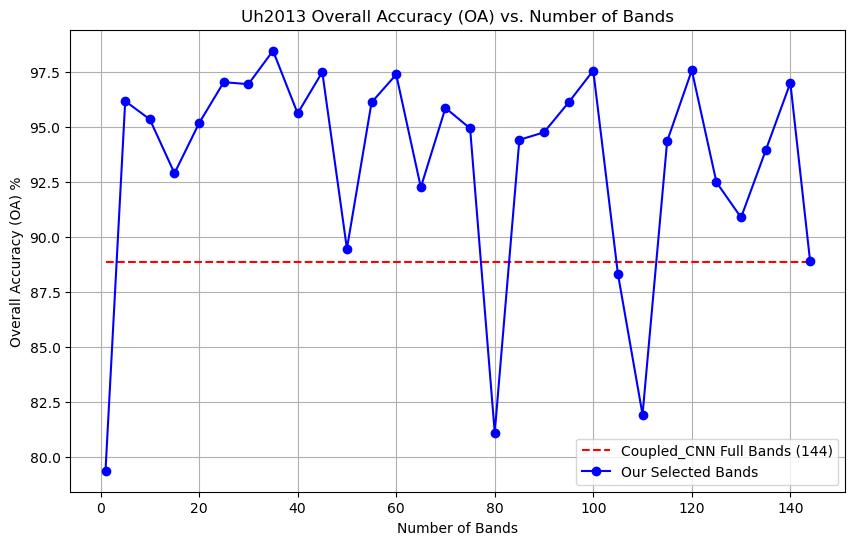

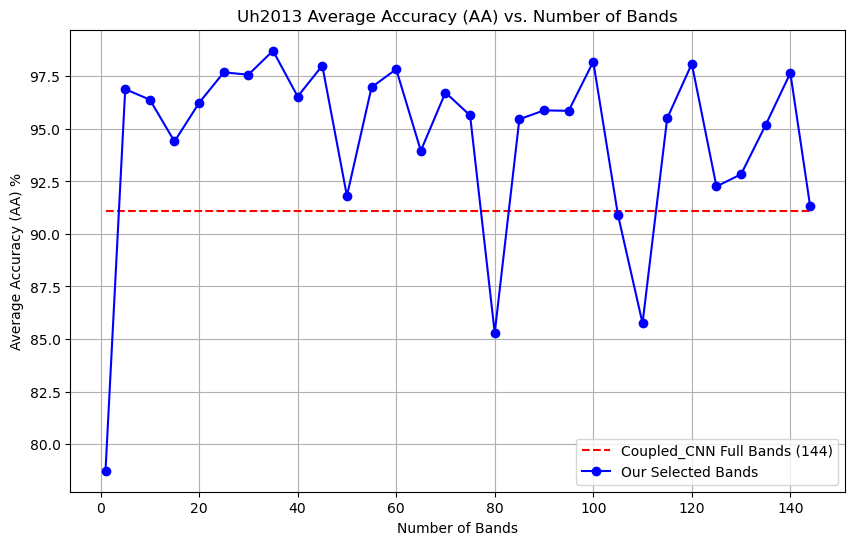

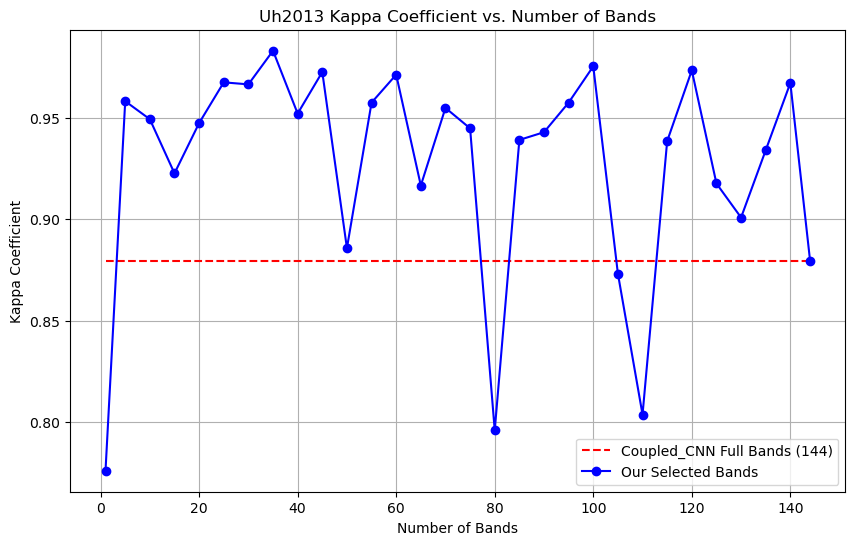

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation data
bands = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 144]

oa_full = 88.86
oa_selected = [79.36, 96.16, 95.33, 92.88, 95.16, 97.02, 96.93, 98.45, 95.6, 97.48, 89.45, 96.1, 97.37, 92.24, 95.85, 94.92, 81.09, 94.4, 94.74, 96.1, 97.55, 88.31, 81.91, 94.34, 97.56, 92.47, 90.87, 93.92, 96.99, 88.9]

aa_full = 91.1
aa_selected = [78.73, 96.89, 96.39, 94.4, 96.24, 97.69, 97.58, 98.72, 96.54, 98.01, 91.81, 96.98, 97.84, 93.96, 96.73, 95.64, 85.29, 95.46, 95.88, 95.86, 98.2, 90.92, 85.75, 95.5, 98.1, 92.26, 92.84, 95.19, 97.66, 91.35]

kappa_full = 0.8794
kappa_selected = [0.776, 0.9583, 0.9494, 0.9227, 0.9475, 0.9676, 0.9666, 0.9832, 0.9522, 0.9727, 0.8858, 0.9576, 0.9714, 0.9167, 0.955, 0.9449, 0.7959, 0.9392, 0.943, 0.9576, 0.9755, 0.8732, 0.8037, 0.9386, 0.9735, 0.9177, 0.9009, 0.9341, 0.9673, 0.8797]

# Plot OA
plt.figure(figsize=(10, 6))
plt.plot(bands, [oa_full]*len(bands), 'r--', label='Coupled_CNN Full Bands (144)')
plt.plot(bands, oa_selected, 'b-o', label='Our Selected Bands')
plt.xlabel('Number of Bands')
plt.ylabel('Overall Accuracy (OA) %')
plt.title('Uh2013 Overall Accuracy (OA) vs. Number of Bands')
plt.legend()
plt.grid(True)
plt.show()

# Plot AA
plt.figure(figsize=(10, 6))
plt.plot(bands, [aa_full]*len(bands), 'r--', label='Coupled_CNN Full Bands (144)')
plt.plot(bands, aa_selected, 'b-o', label='Our Selected Bands')
plt.xlabel('Number of Bands')
plt.ylabel('Average Accuracy (AA) %')
plt.title('Uh2013 Average Accuracy (AA) vs. Number of Bands')
plt.legend()
plt.grid(True)
plt.show()

# Plot Kappa
plt.figure(figsize=(10, 6))
plt.plot(bands, [kappa_full]*len(bands), 'r--', label='Coupled_CNN Full Bands (144)')
plt.plot(bands, kappa_selected, 'b-o', label='Our Selected Bands')
plt.xlabel('Number of Bands')
plt.ylabel('Kappa Coefficient')
plt.title('Uh2013 Kappa Coefficient vs. Number of Bands')
plt.legend()
plt.grid(True)
plt.show()
